In [1]:

import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import sklearn.preprocessing as preprocessing

from network_classes import MNIST_net
from torch_nn_functions import *


plt.rcParams.update({'font.size': 15,
                     'axes.spines.right': False,
                     'axes.spines.top': False,
                     'axes.linewidth':1.2,
                     'xtick.major.size': 6,
                     'xtick.major.width': 1.2,
                     'ytick.major.size': 6,
                     'ytick.major.width': 1.2,
                     'legend.frameon': False,
                     'legend.handletextpad': 0.1,
                     'figure.figsize': [14.0, 4.0],})

In [34]:
from platform import python_version
python_version()

'3.9.7'

In [2]:
tensor_normalize = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.1307],std=[0.3081])])

MNIST_train = torchvision.datasets.MNIST(root='MNIST_data/',train=True,transform=tensor_normalize,download=False)
MNIST_test = torchvision.datasets.MNIST(root='MNIST_data/',train=False,transform=tensor_normalize,download=False)

batch_size = 32
dataloader = torch.utils.data.DataLoader(MNIST_train,
                                         batch_size=batch_size,
                                         shuffle=True)

dataloader_test = torch.utils.data.DataLoader(MNIST_test,
                                              batch_size=10000,
                                              shuffle=True)

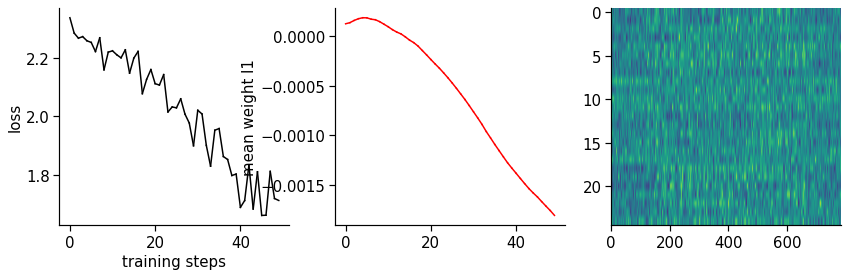

Final accuracy = 57.720001220703125%


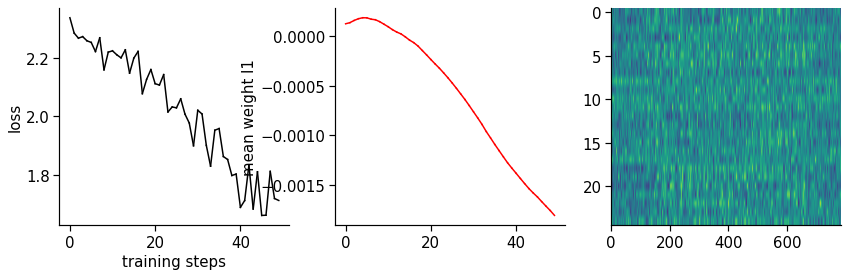

In [3]:
torch.manual_seed(103)
max_batch = 50

model = MNIST_net(batch_size)
model.train(dataloader,
            dataloader_test,
            num_epochs = 1,
            max_batch = max_batch,
            lr = 0.0005,
            plot_dynamic_loss=True)

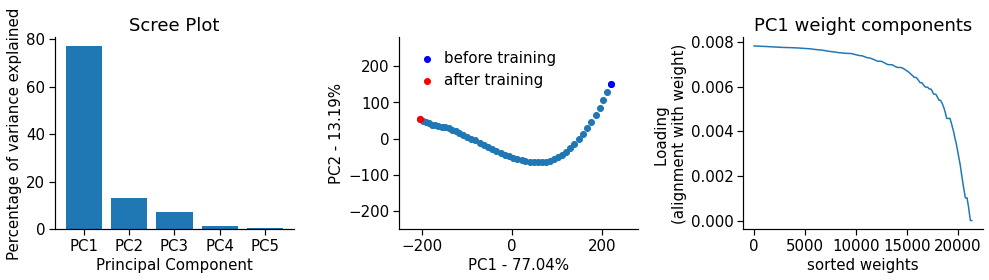

In [4]:
# PCA of the weight space
weight_h = flatten_weight_hist(model)
plot_w_PCs(weight_h)


100%|█████████████████████████████████████████| 100/100 [01:22<00:00,  1.21it/s]


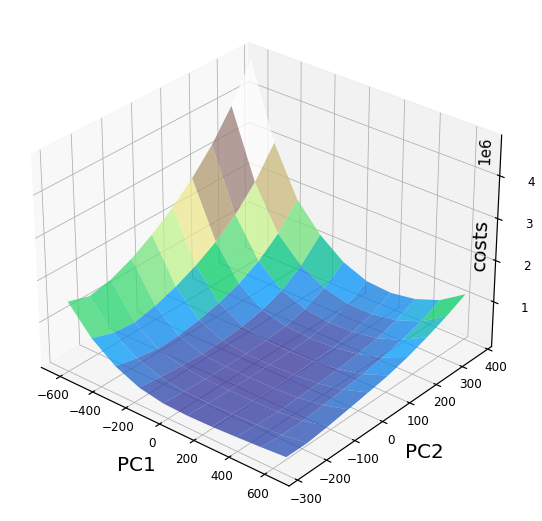

In [35]:
landscape, PC1_mesh, PC2_mesh = get_loss_landscape(model, dataloader_test, 10)

In [36]:
import celluloid
from celluloid import Camera
from matplotlib import animation 
from matplotlib.animation import FuncAnimation, PillowWriter

In [40]:
w = flatten_weight_hist(model)

w = preprocessing.scale(w) # center the data (mean=0, std=1)
pca = PCA(n_components=2)
pca.fit(w)
w_pca = pca.transform(w)

# create grid
PC1 = w_pca[:,0]
PC2 = w_pca[:,1]
delta_PC1 = np.max(PC1) - np.min(PC1)
delta_PC2 = np.max(PC2) - np.min(PC2)
PC1_range = np.linspace(np.min(PC1) - delta_PC1, np.max(PC1) + delta_PC1, 10)
PC2_range = np.linspace(np.min(PC2) - delta_PC2, np.max(PC2) + delta_PC2, 10)

PC1_mesh, PC2_mesh = np.meshgrid(PC1_range, PC2_range)


In [41]:
T.shape

torch.Size([50])

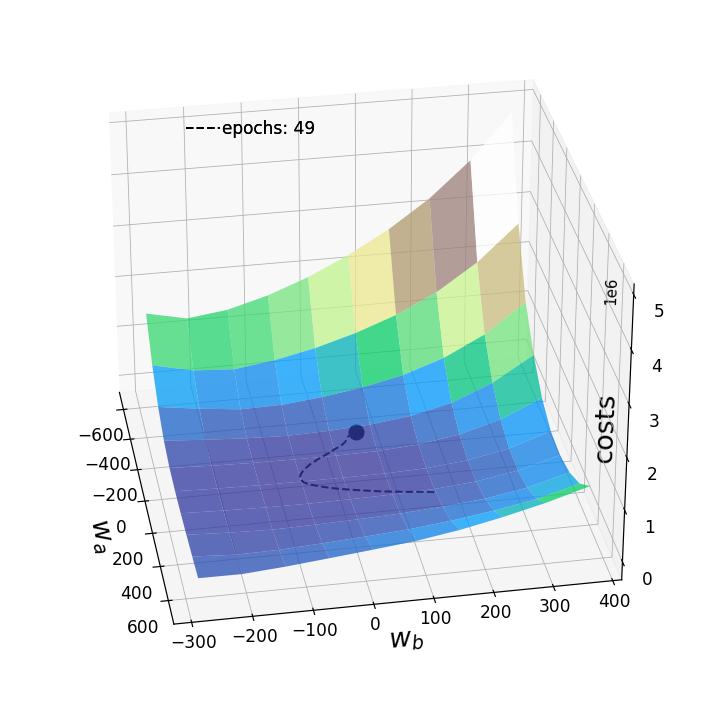

In [42]:
T = model.loss_history[1:]

fig = plt.figure(figsize=(10,10)) # create figure
ax = fig.add_subplot(111,projection='3d' ) 
line_style=["dashed", "dashdot", "dotted"] #linestyles
fontsize_=27 # set axis label fontsize
labelsize_=17 # set tick label fontsize
ax.view_init(elev=30, azim=-10)
ax.set_xlabel(r'$w_a$', fontsize=fontsize_, labelpad=17)
ax.set_ylabel(r'$w_b$', fontsize=fontsize_, labelpad=5)
ax.set_zlabel("costs", fontsize=fontsize_, labelpad=-35)
ax.tick_params(axis='x', pad=12, which='major', labelsize=labelsize_)
ax.tick_params(axis='y', pad=0, which='major', labelsize=labelsize_)
ax.tick_params(axis='z', pad=8, which='major', labelsize=labelsize_)
#ax.set_zlim(4.75,4.802) # set range for z-values in the plot

camera=Camera(fig)

for i in range(50):
    ax.plot(PC1[0:i],PC2[0:i],T[0:i],
                linestyle=line_style[0],linewidth=2,
                color="black", label=str(i))
    ax.scatter(PC1[i],PC2[i],T[i],
               marker='o', s=15**2,
               color="black", alpha=1.0)

    ax.plot_surface(PC1_mesh, PC2_mesh, landscape.numpy(), cmap='terrain', 
                         antialiased=True,cstride=1,rstride=1, alpha=0.75)

    ax.legend([f'epochs: {i}'], loc=(0.25, 0.8),fontsize=17) # set position of legend
    plt.tight_layout() 
    camera.snap() # take snapshot after each iteration
        
animation = camera.animate(interval = 5, # set delay between frames in milliseconds
                          repeat = False,
                          repeat_delay = 0)
animation.save('gd_3.gif', dpi=100)  # save animation 